# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Load data

In [ ]:
mnist_train = datasets.MNIST('.', train=True, transform=Compose([ToTensor()]), download=True)
mnist_test = datasets.MNIST('.', train=False, transform=Compose([ToTensor()]), download=True)

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=True)

# Loss functions

In [ ]:
class MSE_Loss():
  def __init__(self, num_classes=None):
    self.num_classes = num_classes

  def __call__(self, a, y):
    if a.shape != y.shape and a.shape[1] != 1:
      y = self.vectorize(y)
    return 0.5 * np.mean((a - y) ** 2)

  def backward(self, a, y):
    if a.shape != y.shape and a.shape[1] != 1:
      y = self.vectorize(y)
    self.loss = 0.5 * np.mean((a - y) ** 2)
    return (a - y)

  def item(self):
    return self.loss

  def vectorize(self, y):
    """Convert scalar i to 10 dimensional vector with value 1 at i-th index. In case when mse_loss is used for classification task """

    vectorized_y = np.zeros((self.num_classes, y.shape[0]))
    for i, y_ in enumerate(y):
      vectorized_y[y_][i] = 1

    return vectorized_y

# Activation functions

In [ ]:
class Sigmoid():
  def __init__(self):
    pass

  def __call__(self, x):
    self.z_prev = x
    self.a = 1 / (1 + np.exp(-x))

    return self.a

  def backward(self, grad):
    self.grad = grad * self.a * (1 - self.a)
    return self.grad

  def __str__(self):
    return 'activation'

# Layers

In [ ]:
class Linear():
  def __init__(self, input_size, output_size):
    self.w = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
    self.b = np.random.randn(output_size, 1)

  def __call__(self, x):
    """x: input with shape (input_size, batch_size). Returns linear transformation x@w+b with shape (output_size, batch_size)"""
    self.prev_a = x
    self.z = self.w @ self.prev_a + self.b

    return self.z

  def backward(self, grad):
    self.grad_w = grad @ self.prev_a.T
    self.grad_b = grad.sum(axis=1, keepdims=True)

    self.grad = self.w.T @ grad

    return self.grad

  def update_params(self, lr):
    self.w -= lr * self.grad_w
    self.b -= lr * self.grad_b

  def __str__(self):
    return 'linear'

# ANN

In [ ]:
np.random.seed(23)
class ANN():
  def __init__(self):
    self.layers = [Linear(784, 256),
                   Sigmoid(), 
                   Linear(256, 10), 
                   Sigmoid()]

    self.num_layers = len(self.layers)

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x

  def backward(self, grad):
    for layer in self.layers[::-1]:
      grad = layer.backward(grad)

  def update_params(self, lr=1e-4):
    for layer in self.layers:
      if str(layer) != 'activation':
        layer.update_params(lr)

# Model training

In [ ]:
ann = ANN()
loss_fn = MSE_Loss(10)

In [ ]:
epochs = 40
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr = 5e-3

for epoch in range(epochs):
  running_loss = 0.
  total = 0.
  correct = 0
  for i, (x, y) in enumerate(tqdm(train_loader), 1):
    x = x.reshape(x.shape[0], -1).numpy()
    y = y.numpy()

    out = ann(x.T)
    loss = loss_fn.backward(out, y)
    ann.backward(loss)
    ann.update_params(lr)

    running_loss += loss_fn.item()
    total += y.shape[0]
    correct += (out.T.argmax(axis=1) == y).sum()

    if i % 500 == 0:
      print(f'Iter: {i} - Loss: {running_loss / i}')
  train_loss.append(running_loss / len(train_loader))
  train_acc.append(correct / total)

  running_loss = 0.
  total = 0.
  correct = 0
  for i, (x, y) in enumerate(tqdm(test_loader), 1):
    x = x.reshape(x.shape[0], -1).numpy()
    y = y.numpy()

    out = ann(x.T)
    loss = loss_fn(out, y)

    running_loss += loss
    total += y.shape[0]
    correct += (out.T.argmax(axis=1) == y).sum()
  val_loss.append(running_loss / len(test_loader))
  val_acc.append(correct / total)

  print(f'Epoch: {epoch+1} - Loss: {train_loss[-1]} - Accuracy {train_acc[-1]} - Val Loss: {val_loss[-1]} - Val Accuracy: {val_acc[-1]}')

Iter: 500 - Loss: 0.03714625699849737
Iter: 1000 - Loss: 0.030056395815631284
Iter: 1500 - Loss: 0.02570645183452736




Epoch: 1 - Loss: 0.02358542786516349 - Accuracy 0.7394 - Val Loss: 0.013559061756802977 - Val Accuracy: 0.8755


Iter: 500 - Loss: 0.013417668631082636
Iter: 1000 - Loss: 0.01296933221570952
Iter: 1500 - Loss: 0.012476645067814469




Epoch: 2 - Loss: 0.012175037257833395 - Accuracy 0.8786333333333334 - Val Loss: 0.010302888932283266 - Val Accuracy: 0.895


Iter: 500 - Loss: 0.010591201045531342
Iter: 1000 - Loss: 0.010437162568178782
Iter: 1500 - Loss: 0.010351970406771627




Epoch: 3 - Loss: 0.010214692579842997 - Accuracy 0.8930166666666667 - Val Loss: 0.009109844584980797 - Val Accuracy: 0.9052


Iter: 500 - Loss: 0.009587658786627344
Iter: 1000 - Loss: 0.009453020345126519
Iter: 1500 - Loss: 0.009314976903102696




Epoch: 4 - Loss: 0.009279137684560968 - Accuracy 0.8998833333333334 - Val Loss: 0.00849645578082748 - Val Accuracy: 0.909


Iter: 500 - Loss: 0.00892126746790906
Iter: 1000 - Loss: 0.008817909527171543
Iter: 1500 - Loss: 0.00869608498772154




Epoch: 5 - Loss: 0.008662415670101042 - Accuracy 0.9058333333333334 - Val Loss: 0.007988700851419261 - Val Accuracy: 0.914


Iter: 500 - Loss: 0.008428433450504773
Iter: 1000 - Loss: 0.008369106908453666
Iter: 1500 - Loss: 0.008271377274856809




Epoch: 6 - Loss: 0.008192223540423768 - Accuracy 0.9107 - Val Loss: 0.0076749698895092295 - Val Accuracy: 0.9161


Iter: 500 - Loss: 0.007860067064257908
Iter: 1000 - Loss: 0.007887074601385106
Iter: 1500 - Loss: 0.007863366780145778




Epoch: 7 - Loss: 0.007810471849642006 - Accuracy 0.9139333333333334 - Val Loss: 0.0072284901048183066 - Val Accuracy: 0.9195


Iter: 500 - Loss: 0.007505868362951761
Iter: 1000 - Loss: 0.007510947907675429
Iter: 1500 - Loss: 0.007467759062561181




Epoch: 8 - Loss: 0.007478704286377266 - Accuracy 0.9166166666666666 - Val Loss: 0.006954438356095128 - Val Accuracy: 0.922


Iter: 500 - Loss: 0.007176906682220222
Iter: 1000 - Loss: 0.0073114027018587775
Iter: 1500 - Loss: 0.007235142018265516




Epoch: 9 - Loss: 0.007179125708735141 - Accuracy 0.92005 - Val Loss: 0.0067597166414239546 - Val Accuracy: 0.9251


Iter: 500 - Loss: 0.0070775902131689754
Iter: 1000 - Loss: 0.0070033656249758255
Iter: 1500 - Loss: 0.0069005163326464935




Epoch: 10 - Loss: 0.006912865769898599 - Accuracy 0.9233666666666667 - Val Loss: 0.006435276472845443 - Val Accuracy: 0.9269


Iter: 500 - Loss: 0.006788198003840685
Iter: 1000 - Loss: 0.006754581317945841
Iter: 1500 - Loss: 0.006690900685884943




Epoch: 11 - Loss: 0.006667456273306271 - Accuracy 0.92545 - Val Loss: 0.006208142680838336 - Val Accuracy: 0.9295


Iter: 500 - Loss: 0.006448160880893817
Iter: 1000 - Loss: 0.0064612626623199694
Iter: 1500 - Loss: 0.006441815905209453




Epoch: 12 - Loss: 0.006445316469739848 - Accuracy 0.9282333333333334 - Val Loss: 0.006136638783689411 - Val Accuracy: 0.9326


Iter: 500 - Loss: 0.006424146561515014
Iter: 1000 - Loss: 0.00624704668031256
Iter: 1500 - Loss: 0.006278408686175396




Epoch: 13 - Loss: 0.006235284917175845 - Accuracy 0.9296666666666666 - Val Loss: 0.005950160264239057 - Val Accuracy: 0.9334


Iter: 500 - Loss: 0.006163927315925295
Iter: 1000 - Loss: 0.0060815268959612655
Iter: 1500 - Loss: 0.006115169932231771




Epoch: 14 - Loss: 0.006039651201041106 - Accuracy 0.9316833333333333 - Val Loss: 0.005704476122829073 - Val Accuracy: 0.9354


Iter: 500 - Loss: 0.005763012863721635
Iter: 1000 - Loss: 0.0058835228253405515
Iter: 1500 - Loss: 0.005874321286156514




Epoch: 15 - Loss: 0.005858340137977752 - Accuracy 0.9345 - Val Loss: 0.005630356938623786 - Val Accuracy: 0.9359


Iter: 500 - Loss: 0.005690721511189939
Iter: 1000 - Loss: 0.005683359276350739
Iter: 1500 - Loss: 0.005664397270979287




Epoch: 16 - Loss: 0.005682547342512053 - Accuracy 0.9363833333333333 - Val Loss: 0.0054853992169264735 - Val Accuracy: 0.9363


Iter: 500 - Loss: 0.005444794004165353
Iter: 1000 - Loss: 0.005455942680877349
Iter: 1500 - Loss: 0.005522402011784953




Epoch: 17 - Loss: 0.00551850365808004 - Accuracy 0.9384333333333333 - Val Loss: 0.0052632960362778035 - Val Accuracy: 0.939


Iter: 500 - Loss: 0.005312094392084405
Iter: 1000 - Loss: 0.005377792177963271
Iter: 1500 - Loss: 0.0053420666405324556




Epoch: 18 - Loss: 0.00536436906875404 - Accuracy 0.9402333333333334 - Val Loss: 0.0051048248686135405 - Val Accuracy: 0.9397


Iter: 500 - Loss: 0.005185078340552942
Iter: 1000 - Loss: 0.005253138351123732
Iter: 1500 - Loss: 0.005212949244419842




Epoch: 19 - Loss: 0.005214722888490308 - Accuracy 0.9417833333333333 - Val Loss: 0.005004267534368718 - Val Accuracy: 0.942


Iter: 500 - Loss: 0.0051357013160320585
Iter: 1000 - Loss: 0.005078134844339451
Iter: 1500 - Loss: 0.005063061972066021




Epoch: 20 - Loss: 0.0050727104336368 - Accuracy 0.9437833333333333 - Val Loss: 0.004889513347093104 - Val Accuracy: 0.942


Iter: 500 - Loss: 0.0050604440778369
Iter: 1000 - Loss: 0.004950003880968753
Iter: 1500 - Loss: 0.004952375993869378




Epoch: 21 - Loss: 0.004939915262542241 - Accuracy 0.9451666666666667 - Val Loss: 0.004834457825313145 - Val Accuracy: 0.9443


Iter: 500 - Loss: 0.004905304647602629
Iter: 1000 - Loss: 0.004860918506545464
Iter: 1500 - Loss: 0.004801402459593845




Epoch: 22 - Loss: 0.0048128298810268585 - Accuracy 0.9469333333333333 - Val Loss: 0.00471312008135474 - Val Accuracy: 0.945


Iter: 500 - Loss: 0.004735456874722357
Iter: 1000 - Loss: 0.004714100001678659
Iter: 1500 - Loss: 0.004716797647529522




Epoch: 23 - Loss: 0.004692650927825194 - Accuracy 0.9483 - Val Loss: 0.004635305555171541 - Val Accuracy: 0.9469


Iter: 500 - Loss: 0.004461346494257606
Iter: 1000 - Loss: 0.004477115808247502
Iter: 1500 - Loss: 0.004538484682300927




Epoch: 24 - Loss: 0.004579420470267119 - Accuracy 0.94945 - Val Loss: 0.004492392600336505 - Val Accuracy: 0.9481


Iter: 500 - Loss: 0.004462977309279365
Iter: 1000 - Loss: 0.004479232601229752
Iter: 1500 - Loss: 0.004510605052862297




Epoch: 25 - Loss: 0.004472367222466887 - Accuracy 0.95085 - Val Loss: 0.004532887888258618 - Val Accuracy: 0.9492


Iter: 500 - Loss: 0.004350209055365456
Iter: 1000 - Loss: 0.004363505417892478
Iter: 1500 - Loss: 0.004389569109861432




Epoch: 26 - Loss: 0.004368467591324004 - Accuracy 0.9519333333333333 - Val Loss: 0.004319550067836654 - Val Accuracy: 0.9499


Iter: 500 - Loss: 0.004298452256634646
Iter: 1000 - Loss: 0.004324280528876366
Iter: 1500 - Loss: 0.004334496777555215




Epoch: 27 - Loss: 0.004269751855254959 - Accuracy 0.9528 - Val Loss: 0.00424996028950952 - Val Accuracy: 0.9506


Iter: 500 - Loss: 0.004283383960194911
Iter: 1000 - Loss: 0.004237567925670283
Iter: 1500 - Loss: 0.004194968464235627




Epoch: 28 - Loss: 0.004179096525925553 - Accuracy 0.9538833333333333 - Val Loss: 0.00418502136038379 - Val Accuracy: 0.9519


Iter: 500 - Loss: 0.0040565880786202005
Iter: 1000 - Loss: 0.004106477572936607
Iter: 1500 - Loss: 0.004080283266563351




Epoch: 29 - Loss: 0.004084849890774166 - Accuracy 0.9548 - Val Loss: 0.004149503905292309 - Val Accuracy: 0.9531


Iter: 500 - Loss: 0.003979634479729153
Iter: 1000 - Loss: 0.004024190666990466
Iter: 1500 - Loss: 0.0040053483315323855




Epoch: 30 - Loss: 0.003999302877058147 - Accuracy 0.9558 - Val Loss: 0.004014920436574207 - Val Accuracy: 0.9542


Iter: 500 - Loss: 0.003994556691706359
Iter: 1000 - Loss: 0.003915110435972375
Iter: 1500 - Loss: 0.003916146696588274




Epoch: 31 - Loss: 0.003920177553819132 - Accuracy 0.957 - Val Loss: 0.003938733084202246 - Val Accuracy: 0.9555


Iter: 500 - Loss: 0.00399872630763057
Iter: 1000 - Loss: 0.0038450472889445877
Iter: 1500 - Loss: 0.0038556690623523064




Epoch: 32 - Loss: 0.0038381223895359896 - Accuracy 0.95765 - Val Loss: 0.003937535474995948 - Val Accuracy: 0.9557


Iter: 500 - Loss: 0.003788372806104765
Iter: 1000 - Loss: 0.003738620578094146
Iter: 1500 - Loss: 0.0037494755802381327




Epoch: 33 - Loss: 0.0037623873352823846 - Accuracy 0.9586166666666667 - Val Loss: 0.003808796781185089 - Val Accuracy: 0.9571


Iter: 500 - Loss: 0.0037069198392883115
Iter: 1000 - Loss: 0.0037032334767734144
Iter: 1500 - Loss: 0.0037317259672252703




Epoch: 34 - Loss: 0.0036901848508963156 - Accuracy 0.95995 - Val Loss: 0.003829514798445064 - Val Accuracy: 0.9572


Iter: 500 - Loss: 0.0037081460309568506
Iter: 1000 - Loss: 0.0036112598242293973
Iter: 1500 - Loss: 0.0036312482158616893




Epoch: 35 - Loss: 0.0036203728530052894 - Accuracy 0.9602166666666667 - Val Loss: 0.0036770345654577154 - Val Accuracy: 0.9587


Iter: 500 - Loss: 0.0036627839674465363
Iter: 1000 - Loss: 0.003592350286865324
Iter: 1500 - Loss: 0.003579412449076176




Epoch: 36 - Loss: 0.0035543789718019774 - Accuracy 0.9612666666666667 - Val Loss: 0.0037466656106542747 - Val Accuracy: 0.9589


Iter: 500 - Loss: 0.003398148777767129
Iter: 1000 - Loss: 0.0034219493131525075
Iter: 1500 - Loss: 0.0034526075255412827




Epoch: 37 - Loss: 0.0034865394673129378 - Accuracy 0.9623 - Val Loss: 0.0035882746251849887 - Val Accuracy: 0.96


Iter: 500 - Loss: 0.003294712282518824
Iter: 1000 - Loss: 0.003397966259101327
Iter: 1500 - Loss: 0.0034470599700634364




Epoch: 38 - Loss: 0.003425675316992041 - Accuracy 0.9629333333333333 - Val Loss: 0.0035756100735763875 - Val Accuracy: 0.9599


Iter: 500 - Loss: 0.0034663349965417334
Iter: 1000 - Loss: 0.003442856105278282
Iter: 1500 - Loss: 0.0033682858436796027




Epoch: 39 - Loss: 0.0033613135679700728 - Accuracy 0.9636666666666667 - Val Loss: 0.0035979385049711376 - Val Accuracy: 0.9599


Iter: 500 - Loss: 0.003392859076627144
Iter: 1000 - Loss: 0.003328807299210087
Iter: 1500 - Loss: 0.003310692930731113




Epoch: 40 - Loss: 0.0033061023542837963 - Accuracy 0.9643 - Val Loss: 0.0035031268870855457 - Val Accuracy: 0.9607


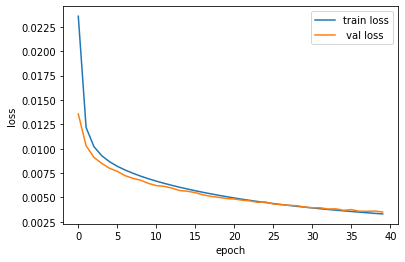

In [ ]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label=' val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

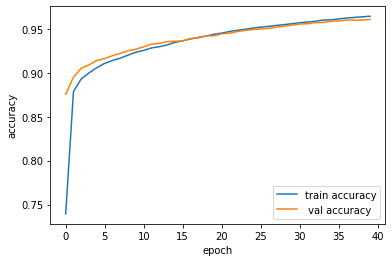

In [ ]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label=' val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

# Make predictions

In [ ]:
x, y = next(iter(test_loader))
x = x.reshape(x.shape[0], -1).numpy()
y = y.numpy()

In [ ]:
out = ann(mnist_test.data.numpy().reshape(-1, 784).T)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [ ]:
out.shape

(10, 10000)

In [ ]:
acc = (out.argmax(axis=0) == mnist_test.targets.numpy()).sum() / len(mnist_test.targets.numpy())
print(f'Test set accuracy {acc}')

Test set accuracy 0.9438


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


True label [5], Predicted: [3]


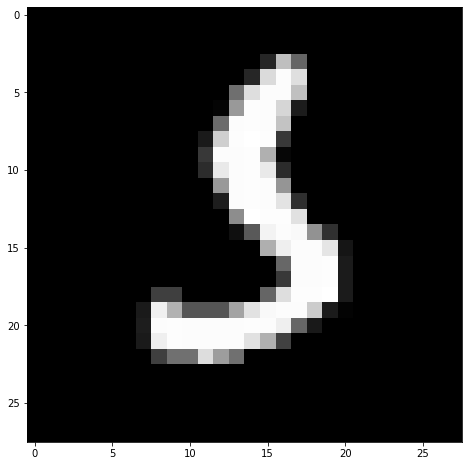

In [ ]:
missclassified_idx = np.arange(len(mnist_test.data.numpy()))[(out.argmax(axis=0) != mnist_test.targets.numpy())]
idx = np.random.choice(missclassified_idx, size=1)
plt.imshow(mnist_test.data.numpy()[idx].reshape(28,28), cmap='gray')
print(f'True label {mnist_test.targets.numpy()[idx]}, Predicted: {ann(mnist_test.data.numpy()[idx].reshape(1, 784).T).argmax(axis=0)}')